In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
#read the excel file
housing = pd.read_excel("housing.xlsx")

In [3]:
#View first few rows of the dataset
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880           129.0   
1    -122.22     37.86                  21         7099          1106.0   
2    -122.24     37.85                  52         1467           190.0   
3    -122.25     37.85                  52         1274           235.0   
4    -122.25     37.85                  52         1627           280.0   

   population  households  median_income ocean_proximity  median_house_value  
0         322         126         8.3252        NEAR BAY              452600  
1        2401        1138         8.3014        NEAR BAY              358500  
2         496         177         7.2574        NEAR BAY              352100  
3         558         219         5.6431        NEAR BAY              341300  
4         565         259         3.8462        NEAR BAY              342200

It can be observed from this dataset that one training example represents a small colony or district or suburb which contains multiple households, each with different number of total rooms, total bedrooms, population and number of households. Let's call this a district. The households have different incomes, so for a district, median income has been calculated. The task is to predict median income of a district given the above attributes. 

In [4]:
housing.shape

(20640, 10)

## Exploratory Data Analysis

In [5]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [6]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

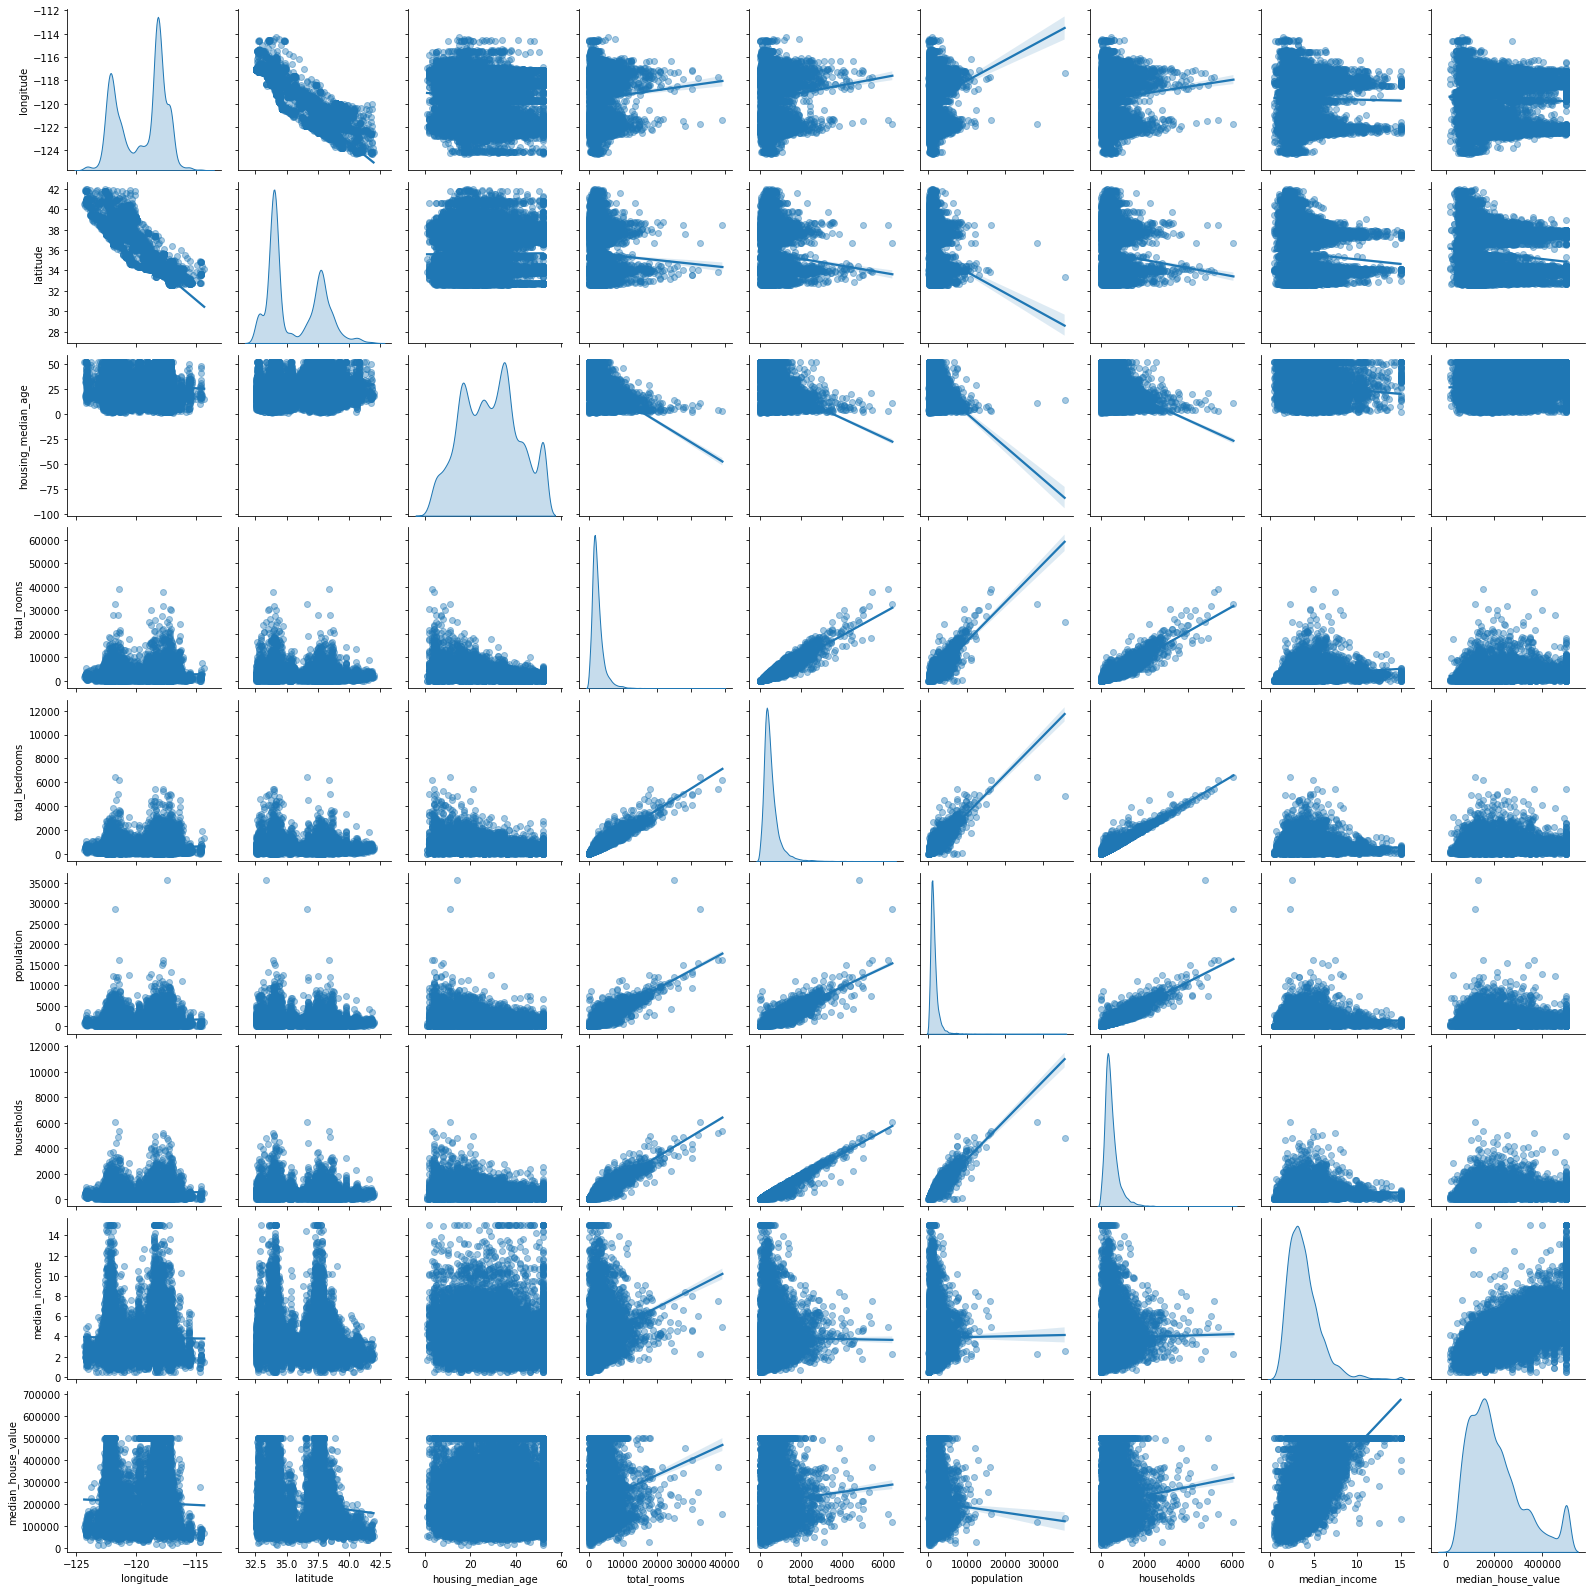

In [7]:
sns.pairplot(housing, kind = 'reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.4}})

## Analyzing 'ocean_proximity'

#### 1. What is the average median household cost of districts in different proximities to ocean?

In [8]:
proximity_cost = housing.groupby(['ocean_proximity']).mean()['median_house_value']
proximity_cost

ocean_proximity
<1H OCEAN     240084.285464
INLAND        124805.392001
ISLAND        380440.000000
NEAR BAY      259212.311790
NEAR OCEAN    249433.977427
Name: median_house_value, dtype: float64

[Text(0.5, 0, 'Proximity to ocean'), Text(0, 0.5, 'Median Housing Cost')]

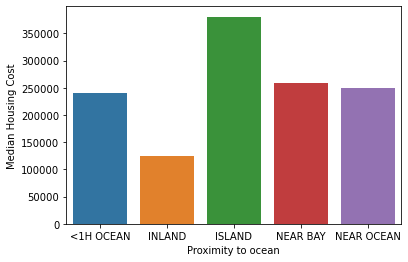

In [9]:
ax = sns.barplot(x = proximity_cost.index, y=proximity_cost.values)
ax.set(xlabel = "Proximity to ocean", ylabel = "Median Housing Cost")

The average housing cost is highest in ISLAND and lowest in INLAND. Let's take a look at how these prices are distributed within each locality. 

#### 2. How are the prices distributed within each locality?

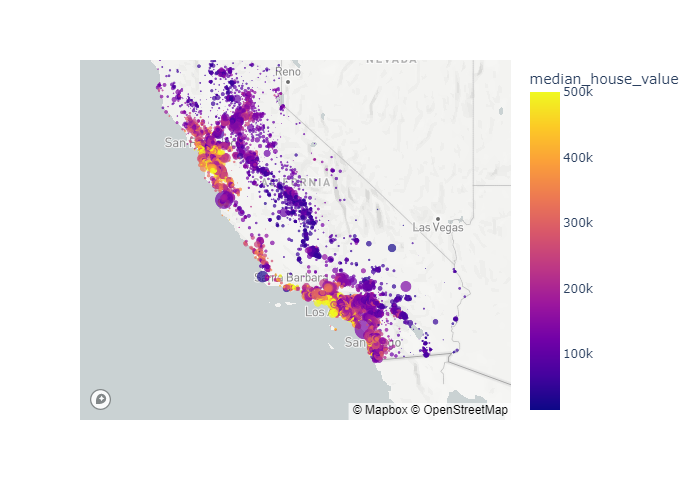

In [10]:
px.set_mapbox_access_token(open(".mapbox_token.txt").read())
fig = px.scatter_mapbox(housing, lat="latitude", lon="longitude", color="median_house_value", size="population",
                   size_max=15, zoom=4.5)
fig.show("png")

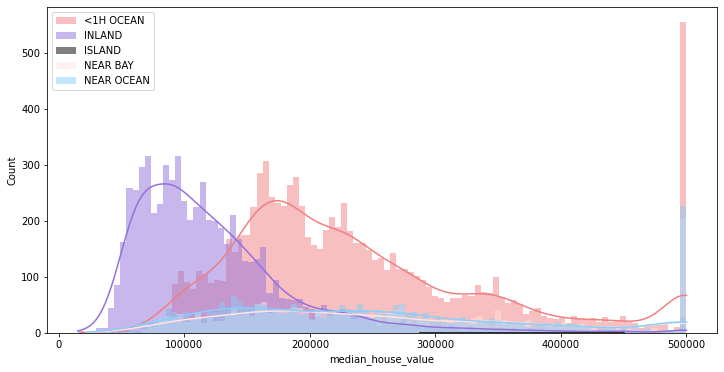

In [11]:
plt.figure(figsize=(12,6))
plt.rcParams['patch.edgecolor'] = 'none'
colors = ['lightcoral','mediumpurple','black','mistyrose','lightskyblue']
for i,col in enumerate(proximity_cost.index):
    sns.histplot(housing['median_house_value'].where(housing['ocean_proximity']==col), 
                 bins=100, label=col, color=colors[i], kde=True)
plt.legend()

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_house_value'>

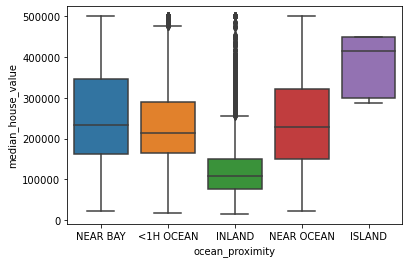

In [12]:
sns.boxplot(x="ocean_proximity", y = "median_house_value", data = housing)

NEAR BAY and NEAR OCEAN are almost identically distributed. While in INLAND the median and average housing cost is low and most of the houses lie between 100k and 200k, there's a good amount of outliers as well. It could be the case that INLAND has some sub locality where the prices are exceptionally high, or due to other factors, which need to be investigated. If we define them as POSH localities i.e. having the same housing price as that of ISLAND =  400000, we can know the percentage of such houses. 


In [13]:
housing[(housing['ocean_proximity']=="<1H OCEAN") 
        & (housing['median_house_value']>400000)]['median_house_value'].count()

929

In [14]:
housing[(housing['ocean_proximity']=="NEAR OCEAN") 
        & (housing['median_house_value']>400000)]['median_house_value'].count()

380

In [15]:
380/2658

0.14296463506395787

929/9136 * 100 = 10.16%. This means roughly 10 % of localities in <1H Ocean are highly priced, while 380/2658 * 100 = 14 % of localities in NEAR OCEAN are highly priced, indicative of presence of posh sub localities. This indicates that the problem is indeed multivariate and there are other factors into play which affect the house prices. However, it is clear that these cannot be considered as outliers and present important information. 


#### 3. How are the districts distributed in different proximities?

In [16]:
proximity_count = housing['ocean_proximity'].value_counts()
proximity_count_perc = housing['ocean_proximity'].value_counts(normalize=True)*100
pd.DataFrame({"count": proximity_count, "percentage": proximity_count_perc}, index=proximity_count.index)

count  percentage
<1H OCEAN    9136   44.263566
INLAND       6551   31.739341
NEAR OCEAN   2658   12.877907
NEAR BAY     2290   11.094961
ISLAND          5    0.024225

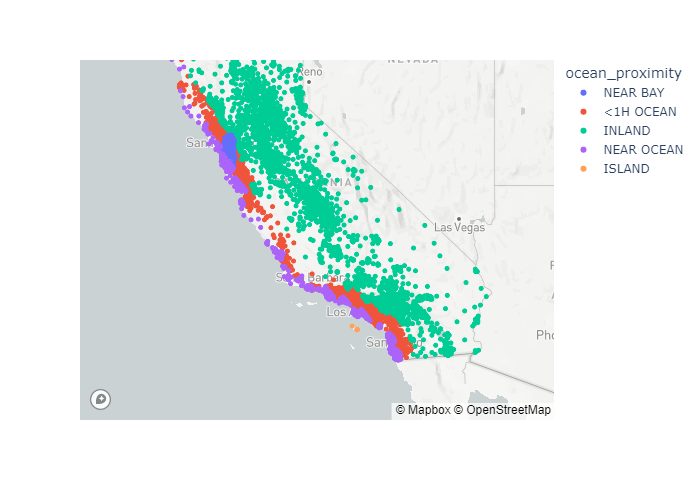

In [17]:
px.set_mapbox_access_token(open(".mapbox_token.txt").read())
fig = px.scatter_mapbox(housing, lat="latitude", lon="longitude", color="ocean_proximity",
                   size_max=15, zoom=4.5)
fig.show("png")

Out of 20000 examples we have only 0.02% examples for ISLAND and nearly 75% examples are from <1H OCEAN and INLAND. The <1H OCEAN is densely populated as compared to INLAND. It might be interesting to see the distribution of median income with respect to ocean_proximity.

#### 4. What is the distribution of median income in different proximities?

In [18]:
proximity_income = housing.groupby('ocean_proximity').mean()['median_income']
proximity_income

ocean_proximity
<1H OCEAN     4.230682
INLAND        3.208996
ISLAND        2.744420
NEAR BAY      4.172885
NEAR OCEAN    4.005785
Name: median_income, dtype: float64

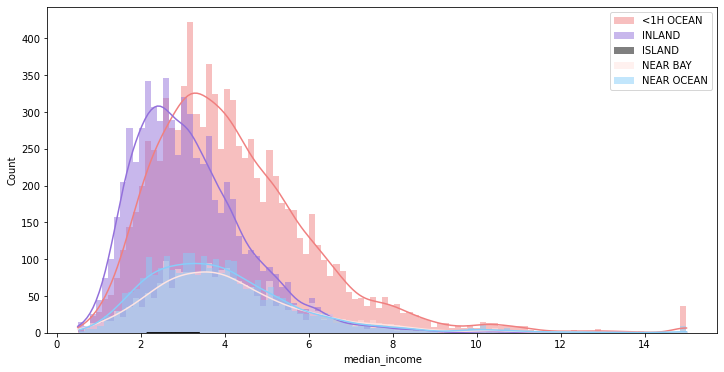

In [19]:
plt.figure(figsize=(12,6))
plt.rcParams['patch.edgecolor'] = 'none'
colors = ['lightcoral','mediumpurple','black','mistyrose','lightskyblue']
for i,col in enumerate(proximity_income.index):
    sns.histplot(housing['median_income'].where(housing['ocean_proximity']==col), 
                 bins=100, label=col, color=colors[i], kde=True)
plt.legend()

<AxesSubplot:xlabel='ocean_proximity', ylabel='median_income'>

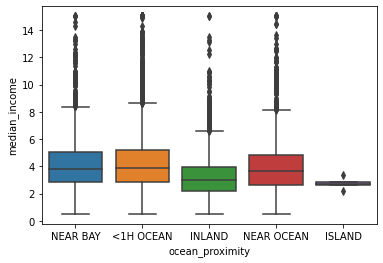

In [20]:
sns.boxplot(x="ocean_proximity", y = "median_income", data = housing)

In all localities except the ISLAND, the income varies from very low to vary high. In ISLAND on the other hand, the income is very fixed. 

<AxesSubplot:>

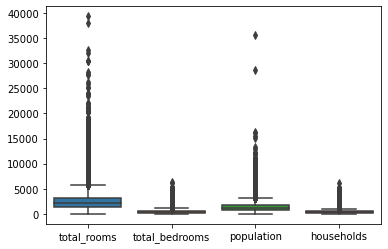

In [21]:
sns.boxplot(data=housing[['total_rooms', 'total_bedrooms','population','households']])

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = housing.drop(columns=['median_house_value'])
y = housing['median_house_value']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,
                                                    stratify=X['ocean_proximity'])
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                stratify=X_test['ocean_proximity'])

## Imputation of missing values

In [25]:
train_params = X_train.describe()
X_train['total_bedrooms'].fillna(train_params.loc['mean','total_bedrooms'], inplace=True)
X_dev['total_bedrooms'].fillna(train_params.loc['mean','total_bedrooms'], inplace=True)
train_params.to_csv("train_params.csv", index=True)

## Correlation Analysis

First check if distribution of different variables remain same after split

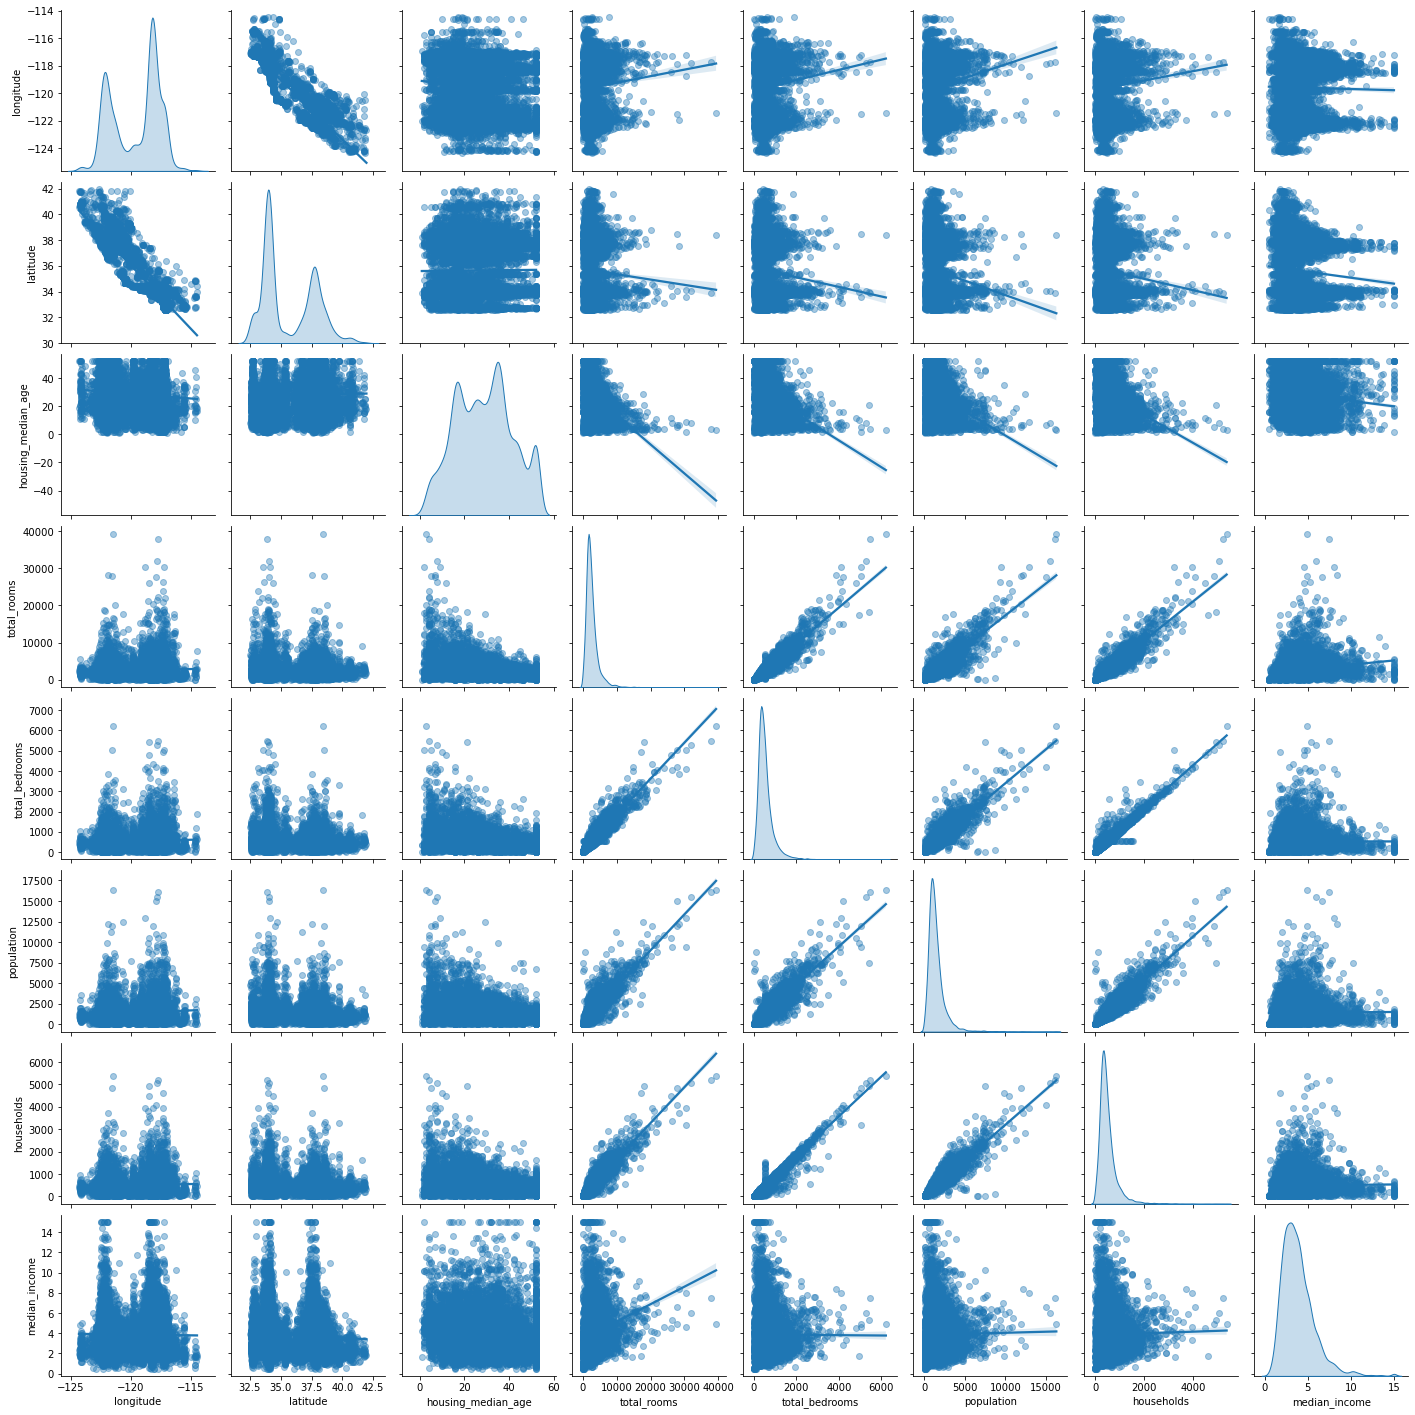

In [26]:
sns.pairplot(X_train, kind = 'reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.4}})

### 1. Pearson Correlation

In [27]:
corr = X_train.drop(columns=['ocean_proximity']).corr()
corr

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924498           -0.107962     0.051856   
latitude            -0.924498  1.000000            0.010700    -0.042112   
housing_median_age  -0.107962  0.010700            1.000000    -0.359137   
total_rooms          0.051856 -0.042112           -0.359137     1.000000   
total_bedrooms       0.077441 -0.072722           -0.317308     0.928706   
population           0.107679 -0.115874           -0.301950     0.864294   
households           0.064580 -0.078509           -0.301286     0.919093   
median_income       -0.016700 -0.082053           -0.117873     0.200139   

                    total_bedrooms  population  households  median_income  
longitude                 0.077441    0.107679    0.064580      -0.016700  
latitude                 -0.072722   -0.115874   -0.078509      -0.082053  
housing_median_age       -0.317308   -0.301950   -0.301286      -0.117873  
total_rooms               0.928706    0.864294    0.919093       0.200139  
total_bedrooms            1.000000    0.880541    0.976602      -0.003572  
population                0.880541    1.000000    0.912470       0.012260  
households                0.976602    0.912470    1.000000       0.016721  
median_income            -0.003572    0.012260    0.016721       1.000000

<AxesSubplot:>

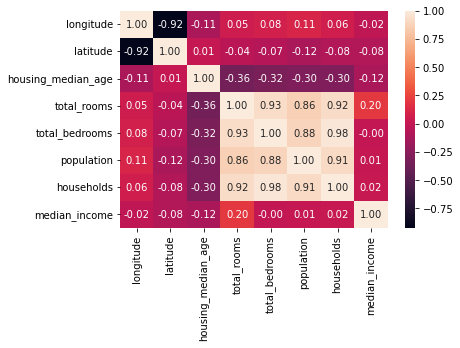

In [28]:
sns.heatmap(corr, annot=True, fmt='.2f')

**total_rooms - households - population - total_bedrooms are all correlated with each other**

**latitude - longitude are highly correlated with each other**


### 2. Variance Inflation Factor

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [30]:
C = add_constant(X_train.drop(columns=['ocean_proximity']))
pd.Series([variance_inflation_factor(C.values, i) 
               for i in range(C.shape[1])], 
              index=C.columns)

const                 16760.589059
longitude                 8.744761
latitude                  8.886258
housing_median_age        1.257674
total_rooms              12.440093
total_bedrooms           30.046178
population                6.735713
households               31.154071
median_income             1.705556
dtype: float64

## Feature Selection and Feature Engineering

### 1. Dummy encoding

In [31]:
X_train = pd.get_dummies(X_train, columns=['ocean_proximity'])
X_train.drop(columns=['ocean_proximity_ISLAND'], inplace=True)
X_dev = pd.get_dummies(X_dev, columns=['ocean_proximity'])
X_dev.drop(columns=['ocean_proximity_ISLAND'], inplace=True)

### Create Baseline Model

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [33]:
def evaluate(model, Xtrain, ytrain, Xdev, ydev):
    mean = Xtrain.mean()
    std = Xtrain.std()
    Xtrain = (Xtrain - mean)/std
    Xdev = (Xdev - mean)/std
    model.fit(Xtrain, ytrain)
    ypred_train = model.predict(Xtrain)
    ypred_dev = model.predict(Xdev)
    train_r2 = r2_score(ytrain,ypred_train)
    train_rmse = np.sqrt(mean_squared_error(ytrain,ypred_train))
    train_score = (train_r2,train_rmse)
    dev_r2 = r2_score(ydev,ypred_dev)
    dev_rmse = np.sqrt(mean_squared_error(ydev,ypred_dev))
    dev_score = (dev_r2,dev_rmse)
    
    results = {'Train': train_score, 'Dev': dev_score}
    
    return results

In [34]:
X_train0, X_dev0 = X_train.copy(), X_dev.copy()

In [35]:
modelbase = LinearRegression()
evaluate(modelbase,X_train0,y_train,X_dev0,y_dev)

{'Train': (0.6513963709779189, 68271.37182776387),
 'Dev': (0.6312323897481658, 70105.49515655354)}

### Feature Engineering Latitude-Longitude using Gaussian Mixture Models

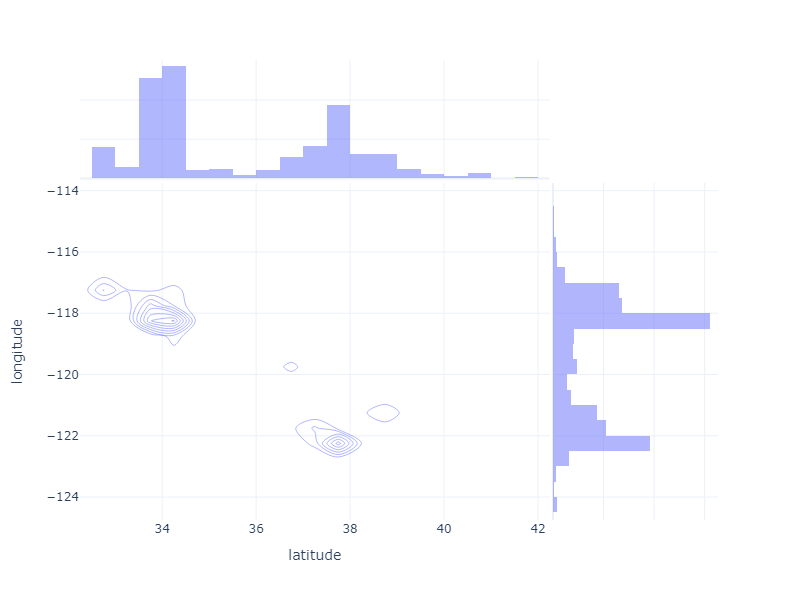

In [36]:
fig = px.density_contour(X_train, x="latitude", y="longitude", marginal_x="histogram", marginal_y="histogram",
                         template='plotly_white', width=600, height=600)
fig.show()

In [37]:
latlong = X_train[['latitude','longitude']].copy()
latlong['latA'] = latlong['latitude'].apply(lambda x: 'lat1' if x>36 else 'lat2' )
latlong['longA'] = latlong['longitude'].apply(lambda x: 'long1' if x>-120 else 'long2')
latlong['cluster'] = latlong['latA'] + latlong['longA']
latlong['cluster'].value_counts()

lat2long1    6884
lat1long2    4778
lat1long1     549
lat2long2     173
Name: cluster, dtype: int64

Visually there are clearly 2 high density clusters and 2 low density clusters. Let's try to separate them out using Gaussian Mixture Models

In [38]:
from sklearn.mixture import GaussianMixture

In [39]:
X_train1 = X_train.copy()
X_dev1 = X_dev.copy()

In [40]:
gmm_lat = GaussianMixture(n_components=2, random_state=42)
gmm_lat.fit(X_train1['latitude'].values.reshape(-1, 1))
X_train1['latitude_class'] = gmm_lat.predict(X_train1['latitude'].values.reshape(-1, 1))

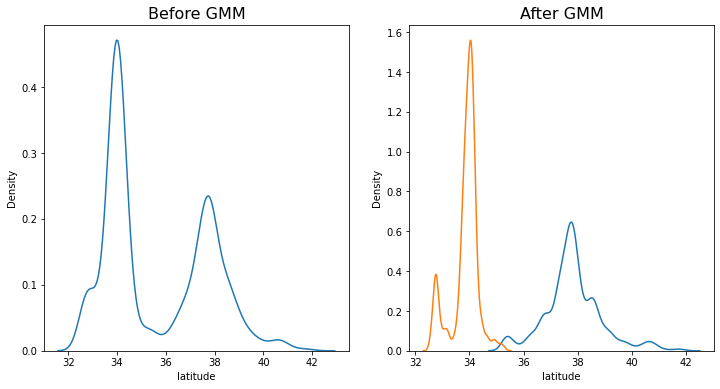

In [41]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.kdeplot(data=X_train1['latitude'], ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=X_train1[X_train1.latitude_class==0].latitude, label='Component 1', ax=ax[1])
sns.kdeplot(data=X_train1[X_train1.latitude_class==1].latitude, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

In [42]:
gmm_long = GaussianMixture(n_components=2, random_state=42)
gmm_long.fit(X_train1['longitude'].values.reshape(-1, 1))
X_train1['longitude_class'] = gmm_long.predict(X_train1['longitude'].values.reshape(-1, 1))

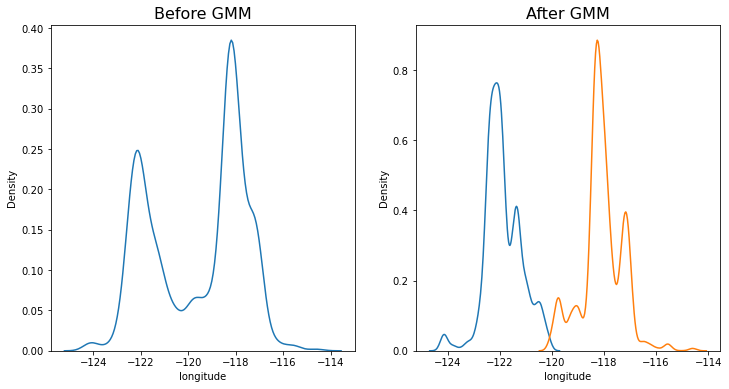

In [43]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.kdeplot(data=X_train1['longitude'], ax=ax[0])
ax[0].set_title('Before GMM', fontsize=16)
sns.kdeplot(data=X_train1[X_train1.longitude_class==0].longitude, label='Component 1', ax=ax[1])
sns.kdeplot(data=X_train1[X_train1.longitude_class==1].longitude, label='Component 2', ax=ax[1])
ax[1].set_title('After GMM', fontsize=16)
plt.show()

In [44]:
X_train1['latitude_class'] = X_train1['latitude_class'].astype(str)
X_train1['longitude_class'] = X_train1['longitude_class'].astype(str)
X_train1['latlongcluster'] = X_train1['latitude_class'] + X_train1['longitude_class']
X_train1 = X_train1.drop(columns=['latitude_class', 'longitude_class'])

In [45]:
X_train1['latlongcluster'].value_counts()

11    6688
00    4776
01     795
10     125
Name: latlongcluster, dtype: int64

In [46]:
X_train1 = pd.get_dummies(X_train1, columns=['latlongcluster'])
X_train1.drop(columns=['latlongcluster_00'], inplace=True)

In [47]:
def gaussian_mixture_prep(X, gmmlat, gmmlong):
    
    X_ = X.copy()
    
    X_['latitude_class'] = gmmlat.predict(X_['latitude'].values.reshape(-1, 1))
    X_['longitude_class'] = gmmlong.predict(X_['longitude'].values.reshape(-1, 1))
    X_['latitude_class'] = X_['latitude_class'].astype(str)
    X_['longitude_class'] = X_['longitude_class'].astype(str)
    X_['latlongcluster'] = X_['latitude_class'] + X_['longitude_class']
    X_ = X_.drop(columns=['latitude_class', 'longitude_class'])
    X_= pd.get_dummies(X_, columns=['latlongcluster'])
    X_.drop(columns=['latlongcluster_00'], inplace=True)
    
    return X_
    

In [48]:
X_dev1 = gaussian_mixture_prep(X_dev1,gmm_lat, gmm_long)

In [49]:
model1 = LinearRegression()
evaluate(model1,X_train1, y_train, X_dev1,y_dev)

{'Train': (0.6591110473310261, 67511.7150997036),
 'Dev': (0.6381738540763456, 69442.54832771329)}

In [50]:
X_train1a = X_train1.drop(columns=['latitude', 'longitude'])
X_dev1a = X_dev1.drop(columns=['latitude', 'longitude'])
model1a = LinearRegression()
evaluate(model1a, X_train1a, y_train, X_dev1a , y_dev)

{'Train': (0.6435710938894019, 69033.37979637588),
 'Dev': (0.6232214823663405, 70862.87091070434)}

In [51]:
X_train1b = X_train1.drop(columns=['longitude'])
X_dev1b = X_dev1.drop(columns=['longitude'])
model1b = LinearRegression()
evaluate(model1b, X_train1b, y_train, X_dev1b , y_dev)

{'Train': (0.6439986344671242, 68991.96420598272),
 'Dev': (0.6232559044574206, 70859.63385790426)}

### Feature Engineering total_rooms, total_bedrooms, population, households

In [53]:
X_train2 = X_train1.copy()
X_dev2 = X_dev1.copy()

In [54]:
colcorr = ['total_rooms','total_bedrooms', 'population', 'households']

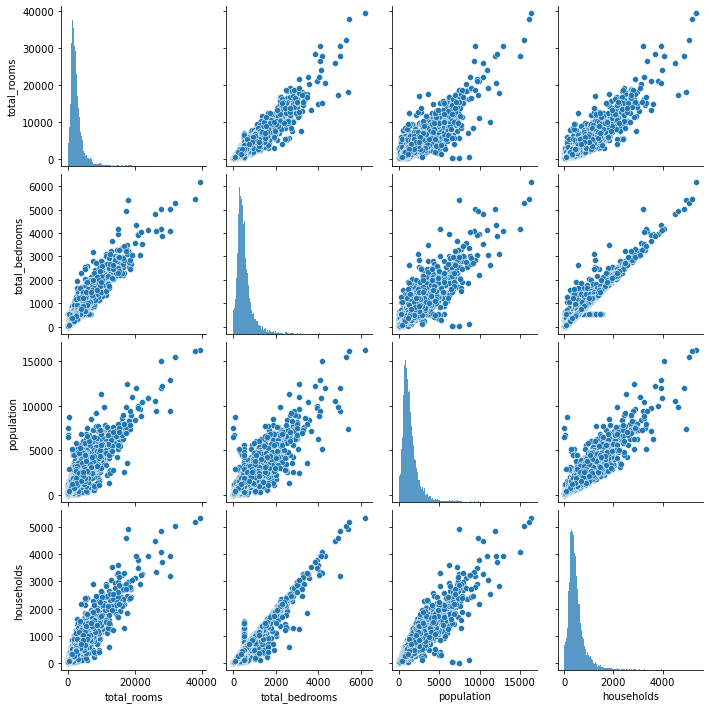

In [55]:
sns.pairplot(X_train2[colcorr])

In [56]:
X_train2['roomsperhousehold'] = X_train2['total_rooms']/X_train2['households']
X_dev2['roomsperhousehold'] = X_dev2['total_rooms']/X_dev2['households']

In [57]:
model2 = LinearRegression()
evaluate(model2,X_train2,y_train,X_dev2,y_dev)

{'Train': (0.6610620585781717, 67318.24282882303),
 'Dev': (0.6412586043148417, 69145.89834142415)}

In [58]:
model2a = LinearRegression()
coldrop2 = ['total_rooms','households','total_bedrooms']
evaluate(model2a, X_train2.drop(columns= coldrop2), y_train, X_dev2.drop(columns=coldrop2), y_dev)

{'Train': (0.6211818839940012, 71168.53852926631),
 'Dev': (0.6184391516041015, 71311.17288069945)}

In [59]:
model2b = LinearRegression()
coldrop2b = ['total_rooms','households']
evaluate(model2b, X_train2.drop(columns= coldrop2b), y_train, X_dev2.drop(columns=coldrop2b), y_dev)

{'Train': (0.6574388903071893, 67677.09459736293),
 'Dev': (0.6370642540722038, 69548.94537624487)}

In [60]:
X_train3 = X_train1.copy()
X_dev3 = X_dev1.copy()

In [61]:
X_train3['total_rooms_per_person'] = X_train3['total_rooms']/X_train3['population']
X_train3['total_bedrooms_per_person'] = X_train3['total_bedrooms']/X_train3['population']
X_train3['households_per_person'] = X_train3['households']/X_train3['population']

X_dev3['total_rooms_per_person'] = X_dev3['total_rooms']/X_dev3['population']
X_dev3['total_bedrooms_per_person'] = X_dev3['total_bedrooms']/X_dev3['population']
X_dev3['households_per_person'] = X_dev3['households']/X_dev3['population']

In [62]:
model3 = LinearRegression()
evaluate(model3,X_train3,y_train, X_dev3,y_dev)

{'Train': (0.6860285825910635, 64791.45523002082),
 'Dev': (0.6801294182549146, 65292.429187508664)}

In [63]:
model3a = LinearRegression()
coldrop3 = ['population','total_rooms','total_bedrooms','households']
evaluate(model3a,X_train3.drop(columns = coldrop3), y_train, X_dev3.drop(columns = coldrop3), y_dev)

{'Train': (0.6826851736179238, 65135.51630610107),
 'Dev': (0.6798780913285059, 65318.07475231528)}

In [64]:
def latlongtoxyz(X):
    X['xcoordinate'] = np.cos(X['latitude'])*np.cos(X['longitude'])
    X['ycoordinate'] = np.cos(X['latitude'])*np.sin(X['longitude'])
    X['zcoordinate'] = np.sin(X['latitude'])
    X = X.drop(columns = ['latitude','longitude'])
    return X

In [65]:
X_train4 = X_train3.copy()
X_dev4 = X_dev3.copy()

In [66]:
X_train4 = latlongtoxyz(X_train4)
X_dev4 = latlongtoxyz(X_dev4)

In [67]:
model4 = LinearRegression()
evaluate(model4,X_train4,y_train,X_dev4,y_dev)

{'Train': (0.6850681884303642, 64890.473516132224),
 'Dev': (0.6802501196996747, 65280.10915156623)}

In [68]:
X_train4.columns.to_list()

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN',
 'latlongcluster_01',
 'latlongcluster_10',
 'latlongcluster_11',
 'total_rooms_per_person',
 'total_bedrooms_per_person',
 'households_per_person',
 'xcoordinate',
 'ycoordinate',
 'zcoordinate']

## Other Algorithms

In [69]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

C:\Users\91902\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [70]:
rfregressor = RandomForestRegressor(random_state=10)
evaluate(rfregressor,X_train4,y_train,X_dev4,y_dev)

{'Train': (0.973530493073996, 18812.46059582068),
 'Dev': (0.8195185466130375, 49044.686908770724)}

In [71]:
gbregressor = GradientBoostingRegressor(random_state=10)
evaluate(gbregressor, X_train4, y_train, X_dev4, y_dev)

{'Train': (0.8108832918504041, 50284.90424690208),
 'Dev': (0.7984934152303815, 51822.731210110054)}

In [72]:
X_train5 = X_train4.copy()
X_dev5 = X_dev4.copy()

X_train5.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1H OCEAN'}, inplace=True)
X_dev5.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1H OCEAN'}, inplace=True)

In [73]:
xgb = XGBRegressor()
evaluate(xgb, X_train5, y_train, X_dev5, y_dev)

C:\Users\91902\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



{'Train': (0.955292958713515, 24448.97419748232),
 'Dev': (0.8359577888877476, 46757.737002573725)}

## Most Important Features

In [74]:
def plotcoefficients(features, values):
    plt.figure(figsize=(12,6))
    plt.bar(features,values)
    plt.xticks(rotation=70)
    plt.show()

In [75]:
ss = StandardScaler()
X_train4a = ss.fit_transform(X_train4)
X_dev4a = ss.transform(X_dev4)

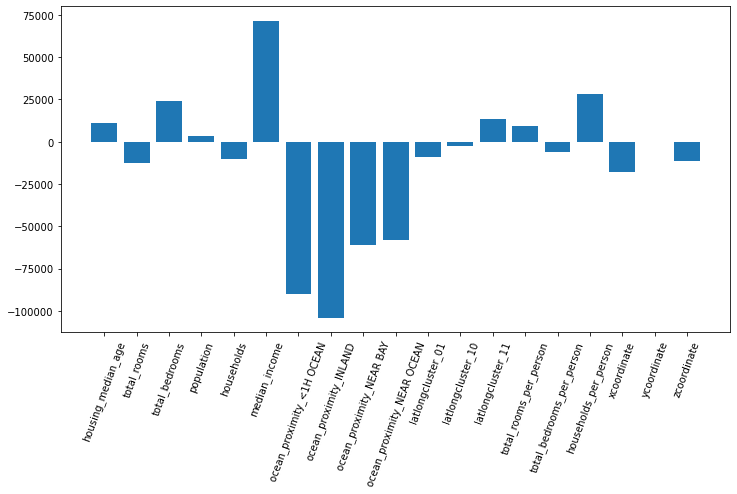

In [76]:
linreg = LinearRegression()
linreg.fit(X_train4a,y_train)
coeflr = linreg.coef_
plotcoefficients(X_train4.columns, coeflr.reshape(-1))

In [77]:
gbreg = GradientBoostingRegressor(random_state=10)
gbreg.fit(X_train4a,y_train)
feat_imp = gbreg.feature_importances_

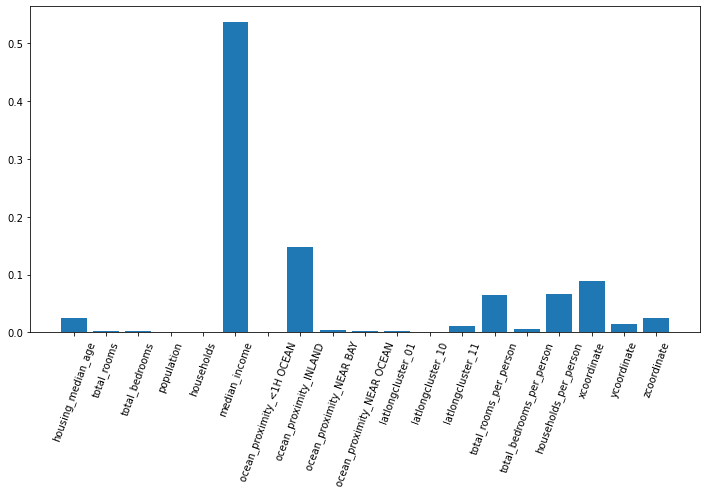

In [78]:
plotcoefficients(X_train4.columns,feat_imp)

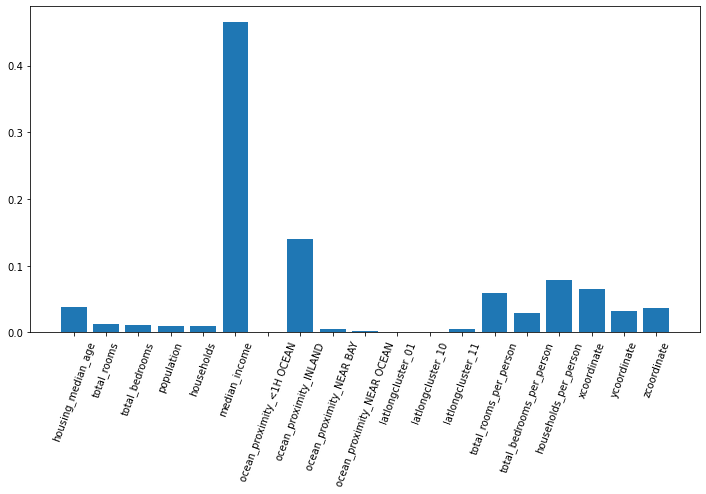

In [79]:
rfreg = RandomForestRegressor(random_state=10)
rfreg.fit(X_train4a,y_train)
feat_imp_rf = rfreg.feature_importances_
plotcoefficients(X_train4.columns,feat_imp_rf)

In [80]:
from joblib import load, dump

In [81]:
dump(gmm_lat,"models/gmmlat.joblib")
dump(gmm_long, "models/gmmlong.joblib")
dump(ss, "models/standardscaler.joblib")
dump(linreg, "models/linearmodel.joblib")

['models/linearmodel.joblib']

## Prediction on new data

In [114]:
import CaliforniaPreprocessing

In [120]:
prep = CaliforniaPreprocessing.Preprocessing()

In [121]:
X_test_tr = prep.transform(X_test)

In [122]:
y_pred_tr = prep.predict(X_test_tr)

In [123]:
r2_score(y_test,y_pred_tr)

0.6742117631836799